# TFM - Predicción potenciales compradores de un ecommerce

Este trabajo, está principalmente enfocado a la creación de un modelo de predicción de potenciales compradores en un ecommerce real relacionado con el mundo empresarial.

Se trata de realizar una clasificación de visitantes a una web de venta online en función de los datos que se han almacenado de ellos y establecer su nivel potencial de compra.

Para ello se dispone de diferentes repositorios con datos históricos relativos a:
* características básicas del registro/lead: fecha registro, procedencia, marca de comprador, cuando compró.
* características identificativas anonimizadas de los mismos: email, ubicación geográfica, tipo de persona.
* log de sus movimientos/navegación en la web.
* información sobre los productos que ha comprado.

**Información relevante del negocio**

Los datos proceden de un ecommerce con sede en Colombia que se dedica a la venta de productos relacionados con la información de empresas del país: Informes Comerciales y módulos de información detallada sobre Datos Financieros, Prensa, Administradores, Incidencias, etc, Informes Sectoriales, Base de datos a medida, Productos de Marketing (mercadeo), Información de accionistas, Información de proveedores y clientes, etc.

Los usuarios potenciales compradores (personas en su nombre o representando a una empresa u otra entidad), llegan a la web del ecommerce por diferentes canales: directorios propios, webs de terceros, desde buscadores por labores de SEO y de SEM, etc.  

Dichos usuarios tienen acceso a diferentes productos de menor contenido a cambio de registrarse en un formulario del site, en el que cumplimentan datos personales, email, teléfono, profesión, etc. El usuario pasa a ser Registrado, y es lo que en el mundo del ecommerce se denomina “lead”.  

Tras el registro se permite el acceso a información muy básica sobre las empresas buscadas (Ficha de empresa), y se otorga la posibilidad de consumir gratis 5 productos de información a los que llamamos perfiles de empresa.  

La oferta caduca a los 30 días.  

El Perfil de empresa es un producto con contenido básico y su objetivo es mostrar a los potenciales compradores el nivel del contenido de los productos que suministra el ecommerce.  

Resumiendo, la dinámica es la siguiente:
* Un usuario busca una empresa en internet o en la web.
* Al seleccionar una de las listadas en la búsqueda, se presenta una Ficha (Identificación) y se crea un registro en el log. Se muestra los productos disponibles para consumir.  
    * Productos Promocionales (Perfil de Empresa). Para usuarios Registrados, si el Usuario se registra.
    * Resto de Productos son de Pago. Es necesario estar registrado y pagar.
* El usuario consume un producto (registro en el log) o vuelve a buscar otra empresa.  

Si el usuario Registrado está interesado en conocer más a fondo una empresa o un determinado producto de pago, se le ofrece la posibilidad de contratación:  
* PPV: Compra puntual del producto
* Bonos: compra de un conjunto de unidades o una cantidad de productos a cambio de un pago anticipado.
* Suscripción: pagando una cantidad periodica permite el acceso y consumo de productos, limitado por el volumen de compra y por la fecha de caducidad de la suscripción

Cuando se produce una de estas contrataciones el usuario “Registrado”, pasa a ser “Cliente”.

El propietario del ecommerce tiene información del usuario de su plataforma de Google Analytics que utiliza para la captación en internet, uso de cookies, estrategias de SEO y SEM, acuerdos con portales.  

Ahora desea dar un paso más y quiere conocer más sobre los usuarios registrados para determinar la probabilidad de conversión a cliente. Saber cuáles son potenciales compradores a partir de los datos de ese registro en sus sistemas, del hábito de consumo de productos, y del tipo de empresa buscada/consultada.  

El conjunto de datos está muy desbalanceado por ello es muy importante determinar a qué usuarios registrados debe dirigir el ecommerce sus campañas de captación.  

Por otra parte, pero relacionado con el mismo tema, desean saber que perfil tienen sus clientes y que variables son las mas influyentes/relevantes en la predicción de compra para modificar la estrategia de marketing y su posicionamiento en Internet.  


------------------------------------

------------------

### 1.1 Librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import ParameterGrid

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier

from collections import Counter

pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings("ignore")

------------------

### 1.2 Variables globales

In [2]:
LABELS = ["No_Cliente","Cliente"]

------------------

### 1.3 Funciones

In [3]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize = (8, 8))
    sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt = "d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

------------------------------------

------------------

A continuación comenzamos leyendo los ficheros que hemos tratado, limpiado y analizado en los procesos anteriores.

Se realizará un análisis sencillo de la estructura y una visualización de varias muestras. 

Además someteremos las variables categóricas a variables *dummies*, de forma que que podamos introducirlas ennuestro modelo.

### 2.1 Lectura de Fichero

In [4]:
df = pd.read_csv('Data/dataset_model_corr.txt', sep = ';', encoding = 'ISO-8859-1')

In [5]:
df.shape

(406267, 26)

In [6]:
df.head(3)

,TIPOUSUARIO,FECHA_REGISTRO_WEEKDAY,FECHA_REGISTRO_MONTH,CANAL_REGISTRO,TIPOEMAIL,BONDAD_EMAIL,TIPO_TELF,IP_CONTINENTE,IP_COUNTRY_PIB,USU_TIPO,USU_TAMANIO,USU_ESTADO,USU_SECTOR_ECONOMICO,1A_DESCGRUPOPROD,1A_EMPCONSUL_EST,1A_EMPCONSUL_SECTOR,IPCASOS,IP_COUNTRY_IDH_NUM,USU_DEPART_DEN_POB,USU_DEPART_IDH,1A_EMPCONSUL_PROV_DENS,1A_EMPCONSUL_PROV_IDH,FICH_PROMO_TOT,PERF_PROMO_TOT,IND_ALTA,IND_CLIENTE
0,PF,1,10,3,GOOHOTYAHMAIL,0,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,NoApl,NoApl,NoApl,NoApl,PERF_PROMO,ACTIVA,TERCIARIO,1,0.767,-1.00,-1.000,47.92,0.782,0,1,0,0
1,PJ,1,5,3,GOOHOTYAHMAIL,1,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,SOC_COMERCIAL_INDUSTRIAL,PQ,ACTIVA,TERCIARIO,PERF_PROMO,ACTIVA,SD,1,0.767,306.38,0.832,47.92,0.782,0,1,0,0
2,PJ,2,9,7,GOOHOTYAHMAIL,1,NO_PUBLICO,AMERICA_SUR,Ingreso mediano alto,SOC_COMERCIAL_INDUSTRIAL,MC,ACTIVA,TERCIARIO,PERF_PROMO,ACTIVA,TERCIARIO,1,0.767,815.17,0.835,4438.75,0.904,0,1,0,0


------------------

### 2.2 Variables dummies

In [7]:
ohe_columns = ['TIPOUSUARIO','FECHA_REGISTRO_WEEKDAY','FECHA_REGISTRO_MONTH','CANAL_REGISTRO','TIPOEMAIL','TIPO_TELF','IP_CONTINENTE','IP_COUNTRY_PIB','USU_TIPO',
               'USU_TAMANIO','USU_ESTADO','USU_SECTOR_ECONOMICO','1A_DESCGRUPOPROD','1A_EMPCONSUL_EST','1A_EMPCONSUL_SECTOR']

In [8]:
final_df = pd.get_dummies(df, columns = ohe_columns)

**Columnas para la predicción**

In [9]:
columnas = ['TIPOUSUARIO_PF','TIPOUSUARIO_PJ', 'FECHA_REGISTRO_WEEKDAY_0','FECHA_REGISTRO_WEEKDAY_1', 'FECHA_REGISTRO_WEEKDAY_2','FECHA_REGISTRO_WEEKDAY_3', 
            'FECHA_REGISTRO_WEEKDAY_4','FECHA_REGISTRO_WEEKDAY_5', 'FECHA_REGISTRO_WEEKDAY_6','FECHA_REGISTRO_MONTH_1', 'FECHA_REGISTRO_MONTH_2',
            'FECHA_REGISTRO_MONTH_3', 'FECHA_REGISTRO_MONTH_4','FECHA_REGISTRO_MONTH_5', 'FECHA_REGISTRO_MONTH_6','FECHA_REGISTRO_MONTH_7', 'FECHA_REGISTRO_MONTH_8',
            'FECHA_REGISTRO_MONTH_9', 'FECHA_REGISTRO_MONTH_10','FECHA_REGISTRO_MONTH_11', 'FECHA_REGISTRO_MONTH_12','CANAL_REGISTRO_1', 'CANAL_REGISTRO_2', 'CANAL_REGISTRO_3',
            'CANAL_REGISTRO_4', 'CANAL_REGISTRO_5', 'CANAL_REGISTRO_6', 'CANAL_REGISTRO_7', 'CANAL_REGISTRO_8', 'CANAL_REGISTRO_9','TIPOEMAIL_ADMINISTRACION','TIPOEMAIL_CORPORATIVO',
            'TIPOEMAIL_DOCENTE','TIPOEMAIL_GOOHOTYAHMAIL','TIPOEMAIL_SINCLASIFICAR','TIPOEMAIL_TEMPORAL','BONDAD_EMAIL','IPCASOS','TIPO_TELF_EXTRANJERO',
            'TIPO_TELF_MOVIL', 'TIPO_TELF_NO_PUBLICO','IP_CONTINENTE_AFRICA','IP_CONTINENTE_AMERICA_NORTE','IP_CONTINENTE_AMERICA_SUR','IP_CONTINENTE_ASIA','IP_CONTINENTE_EUROPA',
            'IP_CONTINENTE_NI','IP_CONTINENTE_OCEANNIA', 'IP_COUNTRY_PIB_Ingreso alto','IP_COUNTRY_PIB_Ingreso mediano alto','IP_COUNTRY_PIB_NI',
            'IP_COUNTRY_PIB_Países de ingreso mediano bajo','IP_COUNTRY_IDH_NUM', 'USU_TIPO_EMPRESARIO INDIVIDUAL','USU_TIPO_ENTIDAD_HOLDING','USU_TIPO_NI','USU_TIPO_NoApl',
            'USU_TIPO_SOC_COMERCIAL_INDUSTRIAL','USU_TIPO_SOC_NO_COMERCIAL','USU_TAMANIO_GR', 'USU_TAMANIO_MC','USU_TAMANIO_MD','USU_TAMANIO_NoApl','USU_TAMANIO_PQ',
            'USU_TAMANIO_SD','USU_ESTADO_ACTIVA','USU_ESTADO_INACTIVA','USU_ESTADO_NoApl', 'USU_ESTADO_REESTRUCTURACION','USU_ESTADO_RELACION_CLINTON','USU_ESTADO_SD',
            'USU_SECTOR_ECONOMICO_CUATERNARIO','USU_SECTOR_ECONOMICO_NoApl', 'USU_SECTOR_ECONOMICO_PRIMARIO','USU_SECTOR_ECONOMICO_QUINARIO','USU_SECTOR_ECONOMICO_SD',
            'USU_SECTOR_ECONOMICO_SECUNDARIO','USU_SECTOR_ECONOMICO_TERCIARIO', 'USU_DEPART_DEN_POB','USU_DEPART_IDH','FICH_PROMO_TOT','PERF_PROMO_TOT','1A_EMPCONSUL_EST_ACTIVA', 
            '1A_EMPCONSUL_EST_INACTIVA', '1A_DESCGRUPOPROD_FICH_PROMO', '1A_DESCGRUPOPROD_PERF_PROMO', '1A_DESCGRUPOPROD_RES_PAGO', '1A_EMPCONSUL_EST_NI', 
            '1A_EMPCONSUL_EST_REESTRUCTURACION', '1A_EMPCONSUL_EST_RELACION_CLINTON', '1A_EMPCONSUL_SECTOR_CUATERNARIO', '1A_EMPCONSUL_SECTOR_PRIMARIO', '1A_EMPCONSUL_SECTOR_QUINARIO',
            '1A_EMPCONSUL_SECTOR_SD', '1A_EMPCONSUL_SECTOR_SECUNDARIO', '1A_EMPCONSUL_SECTOR_TERCIARIO']

-----------------

------------------

### 3.1 Analisis desbalanceo

In [10]:
final_df.shape

(406267, 100)

In [11]:
pd.value_counts(final_df['IND_CLIENTE'], sort = True)

0    395427
1     10840
Name: IND_CLIENTE, dtype: int64

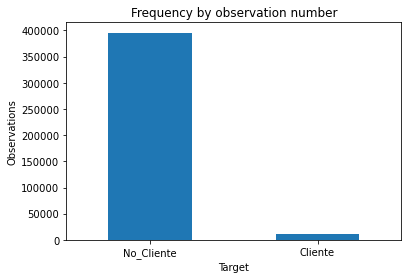

In [12]:
count_classes = pd.value_counts(final_df['IND_CLIENTE'], sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Target")
plt.ylabel("Observations");

In [13]:
print('Los clientes suponen un % del total: ', (10840/final_df.shape[0])*100)

Los clientes suponen un % del total:  2.668196038565771


**Podemos ver un claro desbalanceo donde los clientes no suponen más del 3% de las observaciones**

------------------

------------------

### 4. Creación del Modelo

#### 4.1 Dividimos el set entre features y label

In [14]:
features = final_df[columnas]
labels = final_df['IND_CLIENTE']

In [15]:
features.shape

(406267, 96)

In [16]:
labels.shape

(406267,)

------------------

#### 4.2 Creamos set de entrenamiento y test

In [17]:
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size = 0.3, random_state = 123)

In [18]:
train_x.shape

(284386, 96)

In [19]:
test_x.shape

(121881, 96)

In [20]:
train_y.shape

(284386,)

In [21]:
test_y.shape

(121881,)

------------------

#### 4.3 Selección Hiperparámetros

Definimos una serie de hiperparámetros diferentes para comparar resultados

In [23]:
param_grid = ParameterGrid({'n_estimators': [5, 20, 50, 100, 150],
                            'max_features': [5, 'log2', 'auto', 'sqrt'],
                            'max_depth'   : [None, 3, 5, 7, 10],
                            'criterion'   : ['gini', 'entropy']
                           })

Loop para ajustar un modelo con cada combinación de hiperparámetros

In [24]:
resultados = {'params': [], 'oob_accuracy': []}

In [25]:
for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(train_x, train_y)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 20} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 5} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 20} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 50} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 

In [26]:
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados.head(10)

,oob_accuracy,criterion,max_depth,max_features,n_estimators
19,0.995981,gini,NaN,sqrt,150
14,0.995981,gini,NaN,auto,150
119,0.995974,entropy,NaN,sqrt,150
114,0.995974,entropy,NaN,auto,150
4,0.995949,gini,NaN,5,150
104,0.995942,entropy,NaN,5,150
109,0.995932,entropy,NaN,log2,150
9,0.995932,gini,NaN,log2,150
13,0.995896,gini,NaN,auto,100
18,0.995896,gini,NaN,sqrt,100


**Seleccionamos los mejores hiperparámetros**

In [27]:
print("Mejores hiperparámetros encontrados (oob-accuracy)")
print('--------------------------------------------------')
print("Estimators: \n", resultados.iloc[0,:], "accuracy")

Mejores hiperparámetros encontrados (oob-accuracy)
--------------------------------------------------
Estimators: 
 oob_accuracy    0.995981
criterion           gini
max_depth            NaN
max_features        sqrt
n_estimators         150
Name: 19, dtype: object accuracy


--------------

--------------

#### 4.4 Modelo 1 - Baseline

Nuestro modelo Base, tendrá los parámetros obtenidos como mejores anteriormente.

**Aplicamos los mejores hiperparámetros obtenidos**

In [23]:
rf = RandomForestClassifier(criterion = 'gini', 
                            n_estimators = 150, 
                            max_features = 'sqrt', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(train_x, train_y)

RandomForestClassifier(max_features='sqrt', n_estimators=150, n_jobs=-1,
                       random_state=123)

Observamos los resultados del modelo

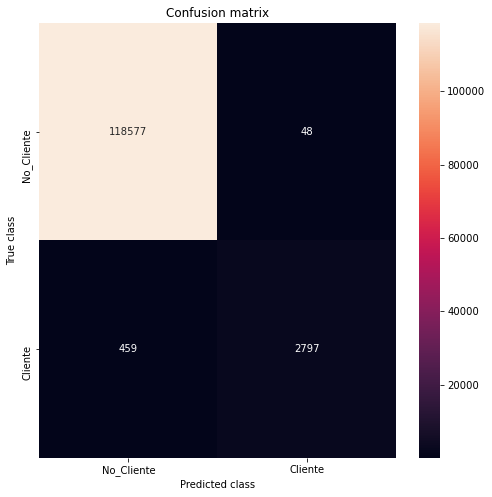

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    118625
           1       0.98      0.86      0.92      3256

    accuracy                           1.00    121881
   macro avg       0.99      0.93      0.96    121881
weighted avg       1.00      1.00      1.00    121881



In [24]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [25]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [26]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FICH_PROMO_TOT,25.826066
IPCASOS,7.685696
PERF_PROMO_TOT,3.709411
CANAL_REGISTRO_1,2.771445
USU_DEPART_IDH,1.991001
USU_DEPART_DEN_POB,1.952091
TIPOEMAIL_GOOHOTYAHMAIL,1.641563
1A_DESCGRUPOPROD_PERF_PROMO,1.536890
TIPOEMAIL_SINCLASIFICAR,1.502153
TIPO_TELF_MOVIL,1.440427


In [27]:
feature_importances[feature_importances['important'] > 0.01].shape

(26, 1)

------

------

------

#### 4.5 Modelo - Aplicando técnicas sobre el desbalanceo

**Estrategias para el manejo de Datos Desbalanceados**

##### **4.5.1 Penalización para compensar**

In [28]:
rf = RandomForestClassifier(criterion = 'gini', 
                            n_estimators = 150, 
                            max_features = 'sqrt', 
                            max_depth = None,
                            n_jobs = -1,
                            random_state = 123,
                            class_weight = 'balanced')

rf.fit(train_x, train_y)

RandomForestClassifier(class_weight='balanced', max_features='sqrt',
                       n_estimators=150, n_jobs=-1, random_state=123)

Observamos los resultados del modelo

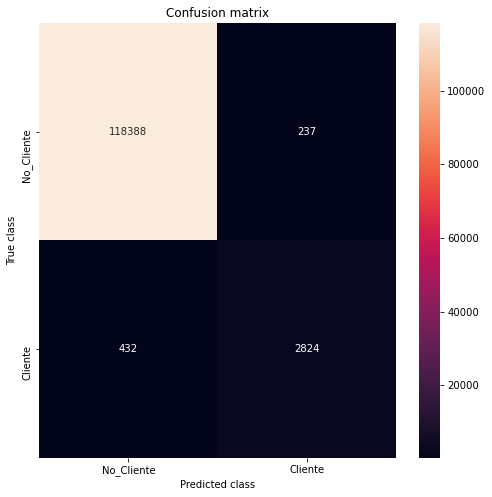

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    118625
           1       0.92      0.87      0.89      3256

    accuracy                           0.99    121881
   macro avg       0.96      0.93      0.95    121881
weighted avg       0.99      0.99      0.99    121881



In [29]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [30]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [31]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FICH_PROMO_TOT,26.516765
IPCASOS,6.877900
PERF_PROMO_TOT,3.352024
USU_DEPART_IDH,3.254253
USU_DEPART_DEN_POB,2.979164
BONDAD_EMAIL,2.864424
USU_TIPO_NoApl,1.869654
IP_COUNTRY_IDH_NUM,1.791196
CANAL_REGISTRO_1,1.635863
USU_TIPO_SOC_COMERCIAL_INDUSTRIAL,1.567826


In [32]:
feature_importances[feature_importances['important'] > 0.01].shape

(25, 1)

------

##### **4.5.2 Subsampling en la clase mayoritaria**

**RandomUnderSampler**

In [22]:
us = RandomUnderSampler(sampling_strategy = 'majority', random_state = 123)
X_train_res, y_train_res = us.fit_resample(train_x, train_y)
 
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 276802, 1: 7584})
Distribution after resampling Counter({0: 7584, 1: 7584})


In [23]:
rf = RandomForestClassifier(criterion = 'gini', 
                            n_estimators = 150, 
                            max_features = 'sqrt', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_features='sqrt', n_estimators=150, n_jobs=-1,
                       random_state=123)

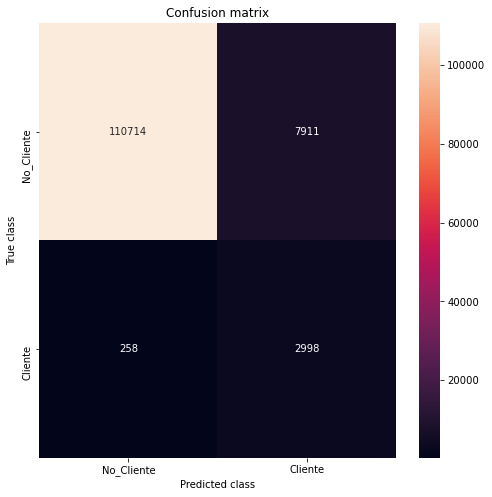

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    118625
           1       0.27      0.92      0.42      3256

    accuracy                           0.93    121881
   macro avg       0.64      0.93      0.69    121881
weighted avg       0.98      0.93      0.95    121881



In [24]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [25]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [26]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FICH_PROMO_TOT,25.729333
IPCASOS,6.353663
USU_DEPART_IDH,4.030786
PERF_PROMO_TOT,3.239593
BONDAD_EMAIL,2.950701
USU_DEPART_DEN_POB,2.695220
USU_TIPO_NoApl,1.941520
USU_TIPO_SOC_COMERCIAL_INDUSTRIAL,1.570438
IP_CONTINENTE_NI,1.536267
IP_COUNTRY_IDH_NUM,1.533273


In [27]:
feature_importances[feature_importances['important'] > 0.01].shape

(26, 1)

------

##### **4.5.3 Oversampling en la clase minoritaria**

**SMOTE**

In [28]:
os =  SMOTE(sampling_strategy = 'minority')
X_train_res, y_train_res = os.fit_resample(train_x, train_y)

print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 276802, 1: 7584})
Distribution labels after resampling Counter({1: 276802, 0: 276802})


In [29]:
rf = RandomForestClassifier(criterion = 'gini', 
                            n_estimators = 150, 
                            max_features = 'sqrt', 
                            max_depth = None, 
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_features='sqrt', n_estimators=150, n_jobs=-1,
                       random_state=123)

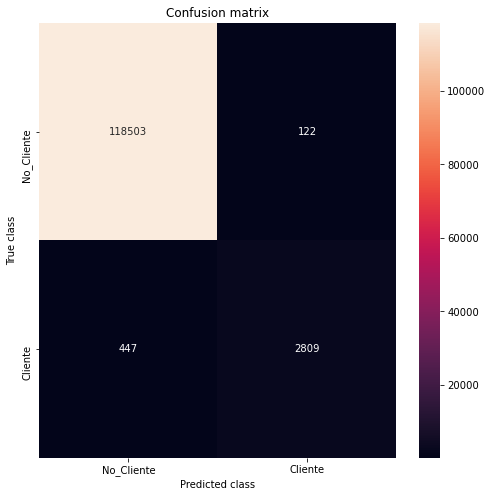

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    118625
           1       0.96      0.86      0.91      3256

    accuracy                           1.00    121881
   macro avg       0.98      0.93      0.95    121881
weighted avg       1.00      1.00      1.00    121881



In [30]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [31]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [32]:
feature_importances[feature_importances['important'] > 0.01]*100

,important
FICH_PROMO_TOT,25.293671
IPCASOS,6.339523
USU_DEPART_DEN_POB,3.220965
USU_DEPART_IDH,3.214544
PERF_PROMO_TOT,2.671464
BONDAD_EMAIL,2.537571
USU_TIPO_NoApl,2.324630
CANAL_REGISTRO_3,2.301735
IP_COUNTRY_IDH_NUM,1.945816
USU_TIPO_EMPRESARIO INDIVIDUAL,1.911731


In [33]:
feature_importances[feature_importances['important'] > 0.01].shape

(27, 1)

------

##### **4.5.4 Combinamos OverSampling con Subsampling**

**Combinando SMOTE & RandomUnderSampler**

In [62]:
over = SMOTE(sampling_strategy = 0.3)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps = steps)

In [63]:
X_train_res, y_train_res = pipeline.fit_resample(train_x, train_y)

In [64]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 276802, 1: 7584})
Distribution after resampling Counter({0: 166080, 1: 83040})


In [65]:
rf = RandomForestClassifier(criterion = 'gini', 
                            n_estimators = 150, 
                            max_features = 'sqrt', 
                            max_depth = None,  
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_features='sqrt', n_estimators=150, n_jobs=-1,
                       random_state=123)

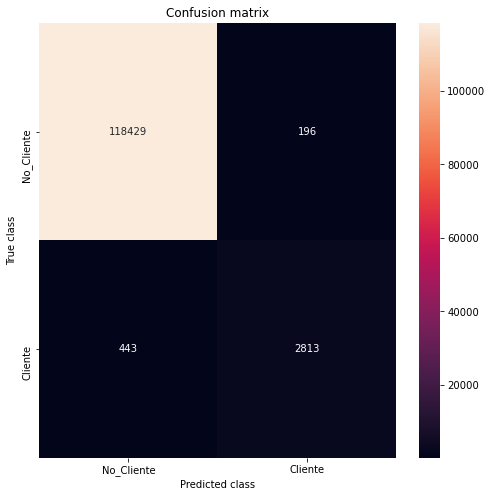

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    118625
           1       0.93      0.86      0.90      3256

    accuracy                           0.99    121881
   macro avg       0.97      0.93      0.95    121881
weighted avg       0.99      0.99      0.99    121881



In [66]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [67]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [68]:
feature_importances[feature_importances['important'] > 0.01] * 100

,important
FICH_PROMO_TOT,25.265035
IPCASOS,7.135344
USU_DEPART_IDH,3.438316
USU_DEPART_DEN_POB,2.870742
PERF_PROMO_TOT,2.867626
BONDAD_EMAIL,2.207399
IP_COUNTRY_IDH_NUM,2.140803
1A_DESCGRUPOPROD_PERF_PROMO,2.009872
CANAL_REGISTRO_3,1.890453
TIPOEMAIL_GOOHOTYAHMAIL,1.705452


In [69]:
feature_importances[feature_importances['important'] > 0.01].shape

(24, 1)

------

**SMOTETomek**

In [70]:
os_us = SMOTETomek(sampling_strategy = 'all')
X_train_res, y_train_res = os_us.fit_resample(train_x, train_y)

In [71]:
print ("Distribution before resampling {}".format(Counter(train_y)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({0: 276802, 1: 7584})
Distribution after resampling Counter({1: 276797, 0: 276797})


In [72]:
rf = RandomForestClassifier(criterion = 'gini', 
                            n_estimators = 150, 
                            max_features = 'sqrt', 
                            max_depth = None,  
                            n_jobs = -1,
                            random_state = 123)

rf.fit(X_train_res, y_train_res)

RandomForestClassifier(max_features='sqrt', n_estimators=150, n_jobs=-1,
                       random_state=123)

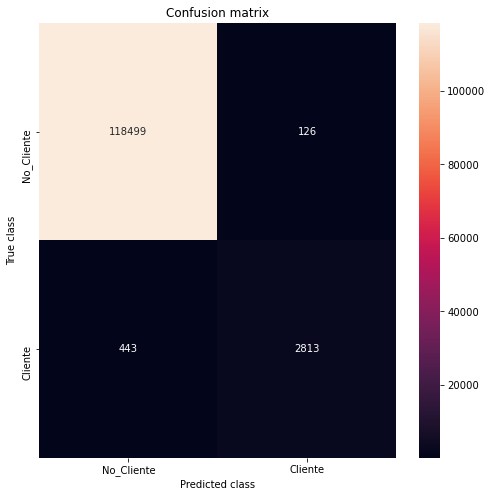

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    118625
           1       0.96      0.86      0.91      3256

    accuracy                           1.00    121881
   macro avg       0.98      0.93      0.95    121881
weighted avg       1.00      1.00      1.00    121881



In [73]:
pred_y = rf.predict(test_x)
mostrar_resultados(test_y, pred_y)

In [74]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = train_x.columns, columns = ['important']).sort_values(['important'], ascending = 0)

In [75]:
feature_importances[feature_importances['important'] > 0.01] * 100

,important
FICH_PROMO_TOT,25.243422
IPCASOS,6.290092
USU_DEPART_IDH,3.290220
USU_DEPART_DEN_POB,3.107726
PERF_PROMO_TOT,2.761778
BONDAD_EMAIL,2.436132
CANAL_REGISTRO_3,2.325608
USU_TIPO_NoApl,2.140704
IP_COUNTRY_IDH_NUM,2.021490
USU_TIPO_EMPRESARIO INDIVIDUAL,1.711867


In [76]:
feature_importances[feature_importances['important'] > 0.01].shape

(27, 1)

------

------

##### **4.5.5 Ensamble de Modelos con Balanceo**

Para esta estrategia usaremos un Clasificador de Ensamble que utiliza Bagging y el modelo será un RandomForest.

**Bagging**

In [78]:
bbc = BalancedBaggingClassifier(base_estimator = RandomForestClassifier(criterion = 'gini', 
                                                                        n_estimators = 150, 
                                                                        max_features = 'sqrt', 
                                                                        max_depth = None, 
                                                                        n_jobs = -1,
                                                                        random_state = 123),
                                sampling_strategy = 'all',
                                n_estimators = 40,
                                replacement = False,
                                random_state = 123)

bbc.fit(train_x, train_y)

BalancedBaggingClassifier(base_estimator=RandomForestClassifier(max_features='sqrt',
                                                                n_estimators=150,
                                                                n_jobs=-1,
                                                                random_state=123),
                          n_estimators=40, random_state=123,
                          sampling_strategy='all')

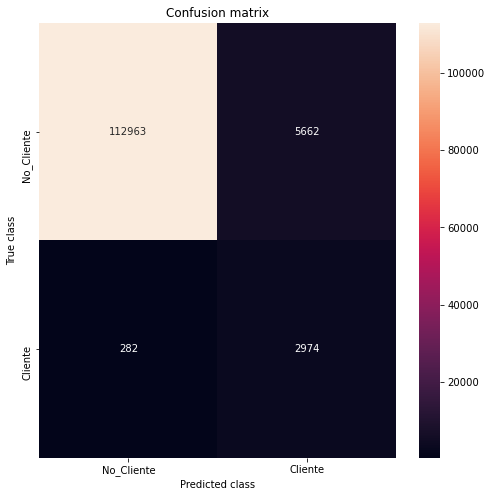

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    118625
           1       0.34      0.91      0.50      3256

    accuracy                           0.95    121881
   macro avg       0.67      0.93      0.74    121881
weighted avg       0.98      0.95      0.96    121881



In [79]:
pred_y = bbc.predict(test_x)
mostrar_resultados(test_y, pred_y)

------

**RUSBoostClassifier**

In [80]:
RUS = RUSBoostClassifier(base_estimator = RandomForestClassifier(criterion = 'gini', 
                                                                 n_estimators = 150, 
                                                                 max_features = 'sqrt', 
                                                                 max_depth = None,
                                                                 n_jobs = -1,
                                                                 random_state = 123),
                                sampling_strategy = 'majority',
                                n_estimators = 20,
                                replacement = False,
                                random_state = 123)

RUS.fit(train_x, train_y)

RUSBoostClassifier(base_estimator=RandomForestClassifier(max_features='sqrt',
                                                         n_estimators=150,
                                                         n_jobs=-1,
                                                         random_state=123),
                   n_estimators=20, random_state=123,
                   sampling_strategy='majority')

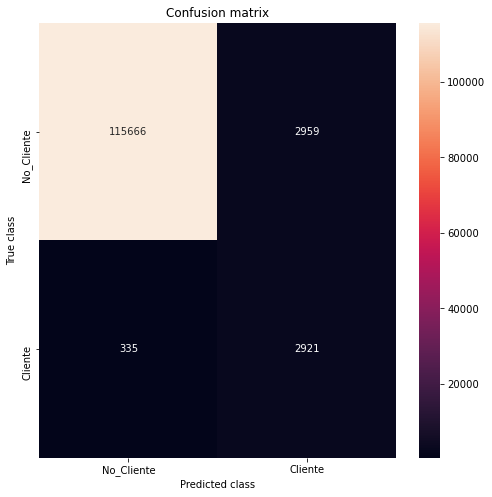

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    118625
           1       0.50      0.90      0.64      3256

    accuracy                           0.97    121881
   macro avg       0.75      0.94      0.81    121881
weighted avg       0.98      0.97      0.98    121881



In [81]:
pred_y = RUS.predict(test_x)
mostrar_resultados(test_y, pred_y)

---------------

---------------

---------------

# CONCLUSIONES

Hemos podido ver claramente que tenemos **un dataset muy desbalanceado** no llegando la clase objetivo ni al 1% del total. Al fin y al cabo esto es más común de lo que suele parecer.

Como bien hemos comentado y se ha visto a lo largo del proceso de desarrollo, la métrica de accuracy no nos es suficientemente útil, ya que el **Accuracy del modelo es básicamente el numero total de predicciones correctas dividido por el número total de predicciones**. Esto hace que al tener una clase muy desbalanceada, la clase que deseamos y que tenemos interés en clasificar, que será la minoritaria, no se clasifique correctamente a pesar de tener un accuracy muy bueno.  

Por ello no nos centraremos en la métrica comentada, será necesario entender las métricas **precision y recall**.  
* **Precision**. La Precisión de una clase define cuan confiable es un modelo en responder si un punto pertenece a esa clase.  
* **Recall**. El Recall de una clase expresa cuan bien puede el modelo detectar a esa clase.  

Con estas 2 métricas podemos tener varias combinaciones en función de sus valores que nos perimitirán escoger entre los diferentes resultados.
* **Alta precision y alto recall**: el modelo maneja perfectamente esa clase.
* **Alta precision y bajo recall**: el modelo no detecta la clase muy bien, pero cuando lo hace es altamente confiable.
* **Baja precisión y alto recall**: La clase detecta bien la clase pero también incluye muestras de otras clases.
* **Baja precisión y bajo recall**: El modelo no logra clasificar la clase correctamente.

Una vez conocidas las metricas que utilizaremos, definiremos el algoritmo que utilizaremos en primera instancia. Utilizaremos el algoritmo RandomForest (RF). **El Random Forest es un algoritmo de clasificación supervisado**. Este algoritmo crea un conjunto de árboles de decisión y a partir de los resultados individuales de cada uno de ellos, se realiza una predicción del comportamiento de un individuo.

**Random Forest funciona así:**

1. Seleccionamos k features (columnas) de las m totales (siendo k menor a m) y creamos un árbol de decisión con esas k características.
2. Creamos n árboles variando siempre la cantidad de k features y también podríamos variar la cantidad de muestras que pasamos a esos árboles (esto es conocido como “bootstrap sample”)
3. Tomamos cada uno de los n árboles y le pedimos que hagan una misma clasificación. Guardamos el resultado de cada árbol obteniendo n salidas.
4. Calculamos los votos obtenidos para cada “clase” seleccionada y consideraremos a la más votada como la clasificación final de nuestro “bosque”.

Debido a la problemática que tenemos del dataset debemos combinar el algoritmo seleccionado con diferentes técnicas que permitan miticar la problemática del desbalanceo. A continuación se explicarán las diferentes técnicas utilizadas en el desarrollo:
* **Ajuste de Parámetros del modelo**: Consiste en ajustar parametros ó metricas del propio algoritmo para intentar equilibrar a la clase minoritaria penalizando a la clase mayoritaria durante el entrenamiento. Ejemplos on ajuste de peso en árboles, también en logisticregression tenemos el parámetro class_weight= “balanced” que utilizaremos en este ejemplo. No todos los algoritmos tienen estas posibilidades. En redes neuronales por ejemplo podríamos ajustar la métrica de Loss para que penalice a las clases mayoritarias.
* **Modificar el Dataset**: podemos eliminar muestras de la clase mayoritaria para reducirlo e intentar equilibrar la situación. Tiene como “peligroso” que podemos prescindir de muestras importantes, que brindan información y por lo tanto empeorar el modelo. Entonces para seleccionar qué muestras eliminar, deberíamos seguir algún criterio. También podríamos agregar nuevas filas con los mismos valores de las clases minoritarias, por ejemplo cuadriplicar nuestras 492 filas. Pero esto no sirve demasiado y podemos llevar al modelo a caer en overfitting.  
* **Muestras artificiales**: podemos intentar crear muestras sintéticas (no idénticas) utilizando diversos algoritmos que intentan seguir la tendencia del grupo minoritario. Según el método, podemos mejorar los resultados. Lo peligroso de crear muestras sintéticas es que podemos alterar la distribución “natural” de esa clase y confundir al modelo en su clasificación.
* **Balanced Ensemble Methods**: Utiliza las ventajas de hacer ensamble de métodos, es decir, entrenar diversos modelos y entre todos obtener el resultado final (por ejemplo “votando”) pero se asegura de tomar muestras de entrenamiento equilibradas.

Realizaremos un modleo base sobre el que comparar los resultados. 

| Modelo | Accuracy  | NoClientes - Precision  | NoClientes - Recall  | NoClientes F1-score | Clientes - Precision | Clientes - Recall | Clientes F1-score | # Variables utilizadas
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Baseline | 1.00 | 1.00 | 1.00 | **1.00** | 0.98 | 0.86 | **0.92** | 26 |  

Dentro de las diferentes técnicas para el tratamiento de datos desbalanceados, existen distintos algoritmos. En concreto se explicarán los utilizados en las tecnicas de **Muestras artificiales** y **Balanced Ensemble Methods**:

1. **Muestras artificiales**:
  * **Subsampling en la clase mayoritaria**.
    * **RandomUnderSampler**: Submuestrear la(s) clase(s) mayoritaria(s) seleccionando muestras al azar con o sin reemplazo
  * **Oversampling en la clase minoritaria**.
    * **SMOTE**: Este objeto es una implementación de SMOTE - Técnica de sobremuestreo de minorías sintéticas.
  * **Combinamos OverSampling con Subsampling**.
    * **SMOTE & RandomUnderSampler**
    * **SMOTE-Tomek**: Sobremuestreo usando SMOTE y limpieza usando enlaces Tomek. Combina sobremuestreo y submuestreo utilizando enlaces SMOTE y Tomek.
    
2. **Balanced Ensemble Methods**:
  * **Ensamble de Modelos con Balanceo**
    * **BalancedBaggingClassifier**: Un clasificador de ensacado con balanceo adicional. Esta implementación de Bagging es similar a la implementación de scikit-learn. Incluye un paso adicional para equilibrar el conjunto de entrenamiento en el momento de ajuste utilizando un muestreador determinado. 
    * **RUSBoostClassifier**: Submuestreo aleatorio integrado en el aprendizaje de AdaBoost. Durante el aprendizaje, el problema del equilibrio de clases se alivia mediante un submuestreo aleatorio de la muestra en cada iteración del algoritmo de refuerzo.

### **Resultados** 

| Modelo |Tecnica |Algoritmo   | Accuracy  | NoClientes - Precision  | NoClientes - Recall  | NoClientes F1-score | Clientes - Precision | Clientes - Recall | Clientes F1-score | # Variables utilizadas
|---|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| Modelo 1 | **Penalización para compensar** | -- | 0.99 | 1.00 | 1.00 | **1.00** | 0.92 | 0.87 | **0.89** | 25 |
| Modelo 2 | **Subsampling en la clase mayoritaria** | RandomUnderSampler | 0.93 | 1.00 | 0.93 | **0.96** | 0.27 | 0.92 | **0.42** | 26 |
| Modelo 3 | **Oversampling en la clase minoritaria** | SMOTE| 1.00 | 1.00 | 1.00 | **1.00** | 0.96 | 0.86 | **0.91** | 26 |
| Modelo 4 | **Combinamos OverSampling con Subsampling** | SMOTE & RandomUnderSampler | 0.99 | 1.00 | 1.00 | **1.00** | 0.93 | 0.86 | **0.9** | 24 |
| Modelo 5 | **Combinamos OverSampling con Subsampling** | SMOTE-Tomek| 1.00 | 1.00 | 1.00 | **1.00** | 0.96 | 0.86 | **0.91** | 27 |
| Modelo 6 | **Ensamble de Modelos con Balanceo** | BalancedBaggingClassifier| 0.95 | 1.00 | 0.95 | **0.97** | 0.34 | 0.91 | **0.5**  | -- |
| Modelo 7 | **Ensamble de Modelos con Balanceo** | RUSBoostClassifier| 0.97 | 1.00 | 0.98 | **0.99** | 0.5 | 0.9 | **0.64** | -- |

Tras los resultados obtenidos y expuestos, podemos concluir que las técnicas que mejores resultados nos han proporcionado estan entre **Penalización para compensar**, **Oversampling en la clase minoritaria** y **Combinamos OverSampling con Subsampling**, (SMOTE y SMOTE-Tomek respectivamente). Los resultados de las técnicas son muy parecidos al del modelo Base.

Análizando las diferentes métricas obtenidas, en primer lugar nos fijamos que todos las diferentes técnicas tienen un F1-score de la clase No Clientes muy similar entre ellas, por lo que marcará la diferencias será la clase Clientes.

Observando que el modelo base y las técnicas SMOTE y SMOTE-Tomek son los que mejor F1 en la clase clientes tienen, analizaremos en detalle la precisión y recall de cada uno.

Entendiendo que el objetivo del negocio es poder desarrollar una estrategia en base a un determinado grupo, lo que premiaremos es el modelo que mejor recall tenga, ya que lo que interesa es detectar bien la clase clientes. El modelo que mejor responde a esto es el que utiliza la técnica **penalizar para compensar**.